In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

In [2]:
root = './tiny-imagenet-200/train/'
files = [os.path.join(root, x, 'images', y) for x in os.listdir(root) for y in os.listdir(os.path.join(root, x, 'images'))]
# Read tiny imagenet metadata (start with small subset)
all_images = np.array([cv2.resize(cv2.imread(x), (64,64)) for x in files[400:600]]) / 255.

In [3]:
# Use VGG19 to extract features (trained on ImageNet)
feature_extraction = tf.keras.applications.VGG19(include_top=False, input_shape=(64,64,3))

In [4]:
feature_extraction.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [5]:
all_features = feature_extraction(all_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [6]:
all_features.shape

TensorShape([200, 2, 2, 512])

In [8]:
reshaped = np.reshape(all_features, (200, 2048))
reshaped.shape

(200, 2048)

In [9]:
# Run kmeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(reshaped)

In [10]:
# Find closest images
representatives = pairwise_distances_argmin(kmeans.cluster_centers_, reshaped)

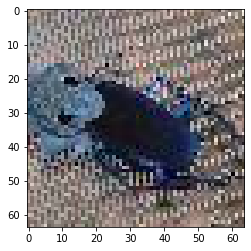

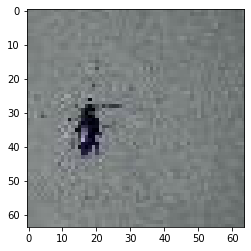

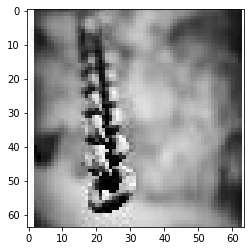

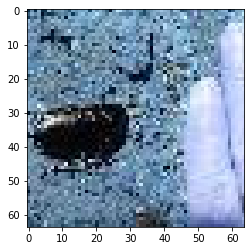

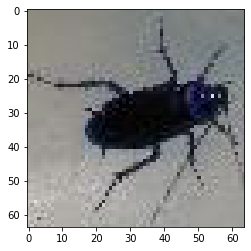

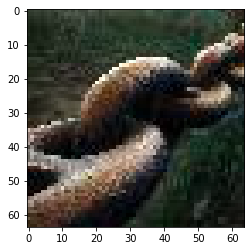

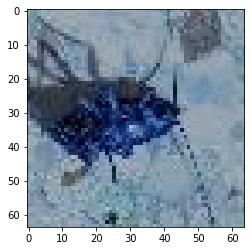

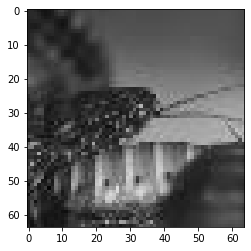

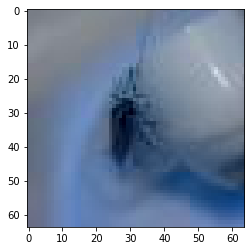

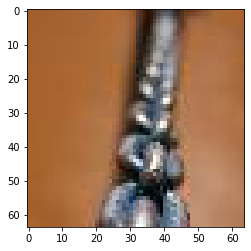

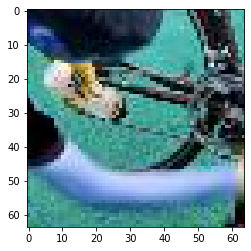

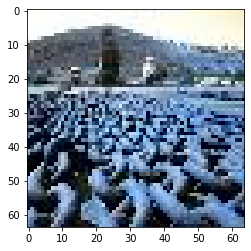

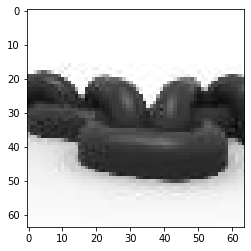

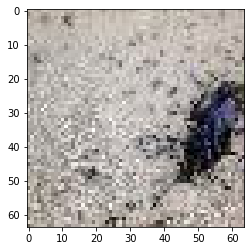

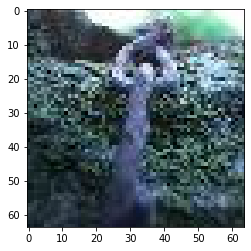

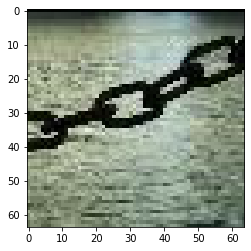

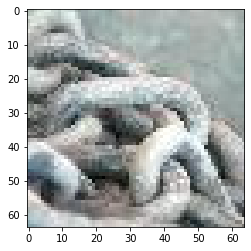

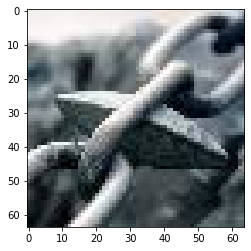

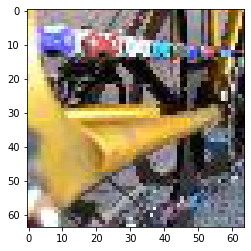

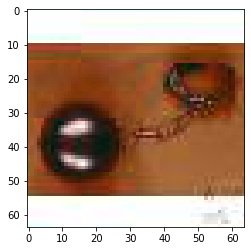

In [11]:
# Show representative images
for i in representatives:
    plt.imshow(all_images[i])
    plt.show()